# Plot water mass properties along 1000m isobath. Try to identify location of CDW.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:33025 Dashboard: /proxy/36801/status,Cluster Workers: 4 Cores: 8 Memory: 100.00 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

#look at years 6-10
start_time='2155-01-01'
end_time='2159-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [4]:
lat_range = slice(-90,-59)

isobath_depth = 1000

In [5]:
yt_ocean = cc.querying.getvar(control,'yt_ocean',master_session,n=1)
print(yt_ocean[600])
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(control,'xt_ocean',master_session,n=1)
st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)


<xarray.DataArray 'yt_ocean' ()>
array(-54.02315489)
Coordinates:
    yt_ocean  float64 -54.02
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y


In [6]:
iso = xr.open_dataset('/home/561/jn8053/g_e14/misc/Antarctic_isobath_1000m.nc')
iso.x

<xarray.DataArray 'x' (dim_0: 6002)>
array([-279.95, -279.85, -279.75, ...,   79.75,   79.85,   79.95])
Dimensions without coordinates: dim_0

In [36]:
iso

<xarray.Dataset>
Dimensions:  (dim_0: 6002)
Dimensions without coordinates: dim_0
Data variables:
    x        (dim_0) float64 -279.9 -279.8 -279.7 -279.7 ... 79.75 79.85 79.95
    y        (dim_0) float64 -66.01 -65.99 -65.99 ... -66.07 -66.06 -66.04

In [7]:
lat_along_contour=iso.y
lon_along_contour=iso.x
num_points=iso.x.shape[0]
num_points

6002

In [56]:
ht_wpartials_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/depth_iso1000m.npy');
ht_wpartials_contour.shape

(6002,)

In [58]:
# convert to longitude coordinate and average into 3 degree longitude bins:
temp_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/temp_iso1000m_control.npy')
rho_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/rho_iso1000m_control.npy')
print(temp_contour.shape,rho_contour.shape)

# in degrees:
bin_width = 3
bin_spacing  = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_lon_coord)

# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points].values)]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)

# average temp from isobath coord into new longitude coord:
slope_temp = np.zeros((75,n_bins))
slope_rho = np.zeros((75,n_bins))
slope_ht = np.zeros((n_bins))
for lon_bin in range(n_bins):
    temp_this_bin = temp_contour[:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    slope_temp[:,lon_bin] = np.mean(temp_this_bin, axis=1)
    rho_this_bin = rho_contour[:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    slope_rho[:,lon_bin] = np.mean(rho_this_bin, axis=1)
    
    ht_this_bin = ht_wpartials_contour[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    slope_ht[lon_bin] = np.mean(ht_this_bin, axis=0)
    
# find average latitude of each bin, so we can plot back on the isobath:
lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
    
slope_temp_control=slope_temp
slope_rho_control=slope_rho

(75, 6002) (75, 6002)


In [10]:
# convert to longitude coordinate and average into 3 degree longitude bins:
temp_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/temp_iso1000m_up.npy')
rho_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/rho_iso1000m_up.npy')
print(temp_contour.shape,rho_contour.shape)

# in degrees:
bin_width = 3
bin_spacing  = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_lon_coord)

# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points].values)]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)

# average temp from isobath coord into new longitude coord:
slope_temp = np.zeros((75,n_bins))
slope_rho = np.zeros((75,n_bins))
for lon_bin in range(n_bins):
    temp_this_bin = temp_contour[:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    slope_temp[:,lon_bin] = np.mean(temp_this_bin, axis=1)
    rho_this_bin = rho_contour[:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    slope_rho[:,lon_bin] = np.mean(rho_this_bin, axis=1)
    
# find average latitude of each bin, so we can plot back on the isobath:
lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
    
slope_temp_up=slope_temp
slope_rho_up=slope_rho

(75, 6002) (75, 6002)


In [11]:
# convert to longitude coordinate and average into 3 degree longitude bins:
temp_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/temp_iso1000m_down.npy')
rho_contour=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/rho_iso1000m_down.npy')
print(temp_contour.shape,rho_contour.shape)

# in degrees:
bin_width = 3
bin_spacing  = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_lon_coord)

# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points].values)]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)

# average temp from isobath coord into new longitude coord:
slope_temp = np.zeros((75,n_bins))
slope_rho = np.zeros((75,n_bins))
for lon_bin in range(n_bins):
    temp_this_bin = temp_contour[:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    slope_temp[:,lon_bin] = np.mean(temp_this_bin, axis=1)
    rho_this_bin = rho_contour[:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    slope_rho[:,lon_bin] = np.mean(rho_this_bin, axis=1)
    
# find average latitude of each bin, so we can plot back on the isobath:
lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
    
slope_temp_down=slope_temp
slope_rho_down=slope_rho

(75, 6002) (75, 6002)


In [12]:
#load density:
rho = cc.querying.getvar(control, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
rho = rho.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_range).mean(dim='time').compute() #.resample({'time':'Y'}).mean('time')

# load temp:
temp = cc.querying.getvar(control, 'temp', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time)
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_range).mean(dim='time').compute()
temp

lon_range  = slice(-115,-110) #-50.04-
rho1_c=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()
temp1_c=temp.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

lon_range  = slice(-210,-205) #-50.04-
rho2_c=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()
temp2_c=temp.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

In [13]:
#load density:
rho = cc.querying.getvar(easterlies_up, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
rho = rho.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_range).mean(dim='time').compute()

# load temp:
temp = cc.querying.getvar(easterlies_up, 'temp', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time)
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_range).mean(dim='time').compute()
temp

lon_range  = slice(-115,-110) #-50.04-
rho1_up=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()
temp1_up=temp.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

lon_range  = slice(-210,-205) #-50.04-
rho2_up=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()
temp2_up=temp.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

In [14]:
#load density:
rho = cc.querying.getvar(easterlies_down, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
rho = rho.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_range).mean(dim='time').compute() 
# load temp:
temp = cc.querying.getvar(easterlies_down, 'temp', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time)
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_range).mean(dim='time').compute()
temp

lon_range  = slice(-115,-110) #-50.04-
rho1_down=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()
temp1_down=temp.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

lon_range  = slice(-210,-205) #-50.04-
rho2_down=rho.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()
temp2_down=temp.sel(xt_ocean=lon_range).mean(dim='xt_ocean').compute()

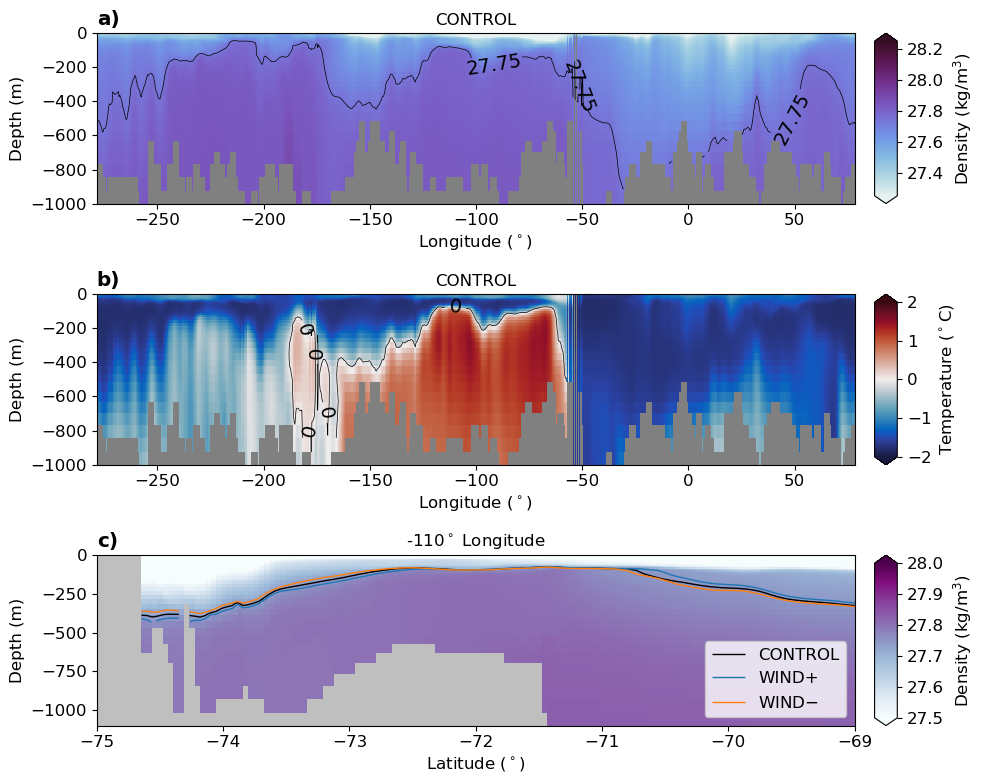

In [15]:
fontsize=12
plt.rcParams['font.size'] = fontsize

levels=np.arange(27.5, 28.5, 0.25)
levels2=np.arange(-2, 3, 0.2)
#levels=np.arange(27.5, 28., 0.05)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
ax = plt.gca()
ax.set_title('a)', loc='left', fontweight='bold')
plt.gca().patch.set_color('.5')
plt.title('CONTROL',fontsize=fontsize)
plt.ylim(-1000,0)
#plt.xlim(-140,-100)
pc=plt.pcolormesh(lon_bin_midpoints,-st_ocean,slope_rho_control-1000,cmap=cmocean.dense,vmin=27.25,vmax=28.25)
pr=plt.contour(lon_bin_midpoints,-st_ocean,slope_rho_control-1000,levels=[27.75],colors='k',linewidths=0.5)
#pr=plt.contour(lon_bin_midpoints,-st_ocean,slope_temp-273.13,levels=[0],colors='r',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=14)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(lon_bin_midpoints,-st_ocean,slope_temp-273.13,levels=[0],colors='r',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'Density (kg/m$^3$)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=12)

plt.subplot(3,1,2)
ax = plt.gca()
ax.set_title('b)', loc='left', fontweight='bold')
plt.gca().patch.set_color('.5')
plt.title('CONTROL',fontsize=fontsize)
plt.ylim(-1000,0)
#plt.xlim(-140,-100)
pc=plt.pcolormesh(lon_bin_midpoints,-st_ocean,slope_temp_control-273.13,cmap=cmocean.balance,vmin=-2,vmax=2)
pr=plt.contour(lon_bin_midpoints,-st_ocean,slope_temp_control-273.13,levels=[0],colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=14)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(lon_bin_midpoints,-st_ocean,slope_temp-273.13,levels=[0],colors='r',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temperature ($^\circ$C)',fontsize=12,labelpad=5)
cbar.ax.tick_params(labelsize=12)

plt.subplot(3,1,3)
ax = plt.gca()
ax.set_title('c)', loc='left', fontweight='bold')
plt.title('-110$^\circ$ Longitude',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-75,-69)
plt.ylim(-1100,0)

p1=plt.pcolormesh(rho1_c.yt_ocean,-rho1_c.st_ocean,rho1_c,vmin=27.5,vmax=28.,cmap=plt.cm.BuPu)
p2=plt.contour(rho1_c.yt_ocean,-rho1_c.st_ocean,rho1_c,levels=[27.75],colors='k',label='CONTROL',linewidths=1)
#plt.clabel(pr, pr.levels, inline=True,fontsize=14)
p3=plt.contour(rho1_up.yt_ocean,-rho1_up.st_ocean,rho1_up,levels=[27.75],colors='C0',label='WIND+',linewidths=1)
p4=plt.contour(rho1_down.yt_ocean,-rho1_down.st_ocean,rho1_down,levels=[27.75],colors='C1',label='WIND$-$',linewidths=1)

plt.tick_params(labelsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)

h2,_ = p2.legend_elements()
h3,_ = p3.legend_elements()
h4,_ = p4.legend_elements()
ax.legend([h2[0], h3[0], h4[0]], ['CONTROL', 'WIND+','WIND$-$'],fontsize=12, loc="lower right")

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'Density (kg/m$^3$)',fontsize=12,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

#plt.legend([arr1, arr2, arr3], ['u','v','u+v'])

plt.tight_layout()

plt.savefig('Figure5.pdf')

In [39]:
#!pip install haversine
#import haversine as hs

#https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b

In [41]:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
#contour_file
for k in contour_file.iterkeys():
    print(k)

contour_mask_numbered
contour_masked_above
contour_depth
xt_ocean
yt_ocean
mask_y_transport
mask_x_transport
mask_y_transport_numbered
mask_x_transport_numbered


In [42]:
contour_file['contour_depth']

array(1000)

In [21]:
temp_contour_control=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/temp_iso1000m_control.npy')
rho_contour_control=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/rho_iso1000m_control.npy')
print(temp_contour_control.shape,rho_contour_control.shape)



(75, 6002) (75, 6002)


In [48]:
iso

<xarray.Dataset>
Dimensions:  (dim_0: 6002)
Dimensions without coordinates: dim_0
Data variables:
    x        (dim_0) float64 -279.9 -279.8 -279.7 -279.7 ... 79.75 79.85 79.95
    y        (dim_0) float64 -66.01 -65.99 -65.99 ... -66.07 -66.06 -66.04

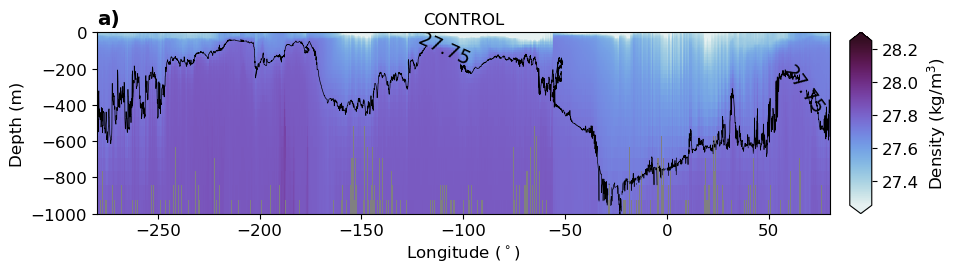

In [51]:
#plot as distance along contour
fontsize=12
plt.rcParams['font.size'] = fontsize

levels=np.arange(27.5, 28.5, 0.25)
levels2=np.arange(-2, 3, 0.2)
#levels=np.arange(27.5, 28., 0.05)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
ax = plt.gca()
ax.set_title('a)', loc='left', fontweight='bold')
plt.gca().patch.set_color('.5')
plt.title('CONTROL',fontsize=fontsize)
plt.ylim(-1000,0)
#plt.xlim(-140,-100)
pc=plt.pcolormesh(iso.x,-st_ocean,rho_contour_control-1000,cmap=cmocean.dense,vmin=27.25,vmax=28.25)
pr=plt.contour(iso.x,-st_ocean,rho_contour-1000,levels=[27.75],colors='k',linewidths=0.5)
#pr=plt.contour(lon_bin_midpoints,-st_ocean,slope_temp-273.13,levels=[0],colors='r',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=14)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(lon_bin_midpoints,-st_ocean,slope_temp-273.13,levels=[0],colors='r',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'Density (kg/m$^3$)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=12)

(6002,) (1428,)


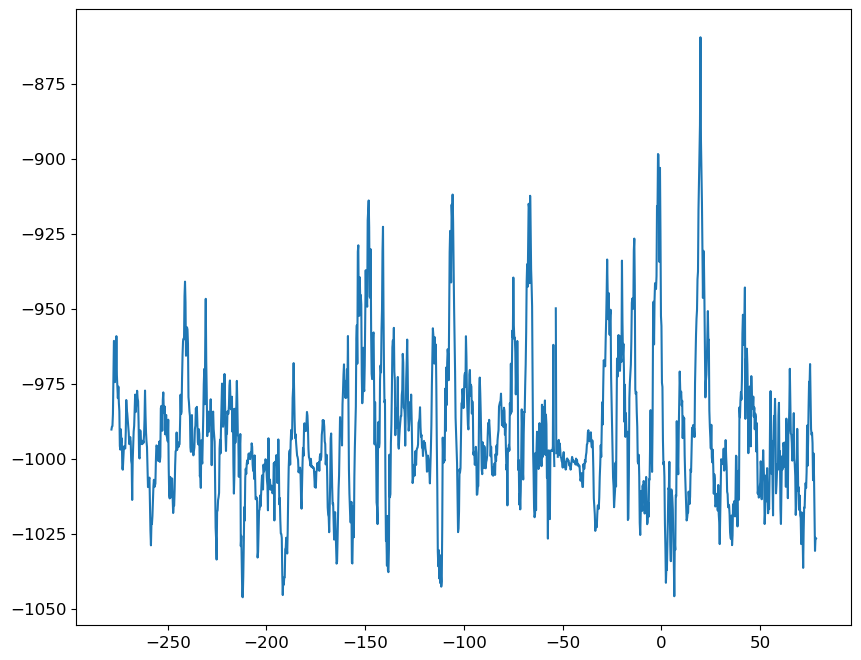

In [70]:
ht_wpartials=np.load('/g/data/v45/pas561/jnb/easterlies-collaborative-project/notebooks/cdw/depth_iso1000m.npy');
print(ht_wpartials.shape,slope_ht.shape)
#plot as distance along contour

plt.figure(figsize=(10,8))
plt.plot(lon_bin_midpoints,-slope_ht)



In [76]:
#np.array([[1, 2], [3, 4]])
#tmp_rho=np.array([[slope_ht],[slope_rho_control]])
print(lon_bin_midpoints.shape,slope_ht.shape,slope_rho_control.shape,tmp_rho.shape)

(1428,) (1428,) (75, 1428) (2, 1)


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

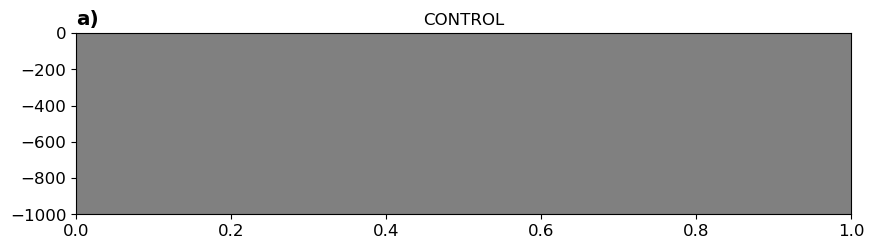

In [61]:
fontsize=12
plt.rcParams['font.size'] = fontsize

levels=np.arange(27.5, 28.5, 0.25)
levels2=np.arange(-2, 3, 0.2)
#levels=np.arange(27.5, 28., 0.05)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
ax = plt.gca()
ax.set_title('a)', loc='left', fontweight='bold')
plt.gca().patch.set_color('.5')
plt.title('CONTROL',fontsize=fontsize)
plt.ylim(-1000,0)
#plt.xlim(-140,-100)
pc=plt.pcolormesh(lon_bin_midpoints,-slope_ht,slope_rho_control-1000,cmap=cmocean.dense,vmin=27.25,vmax=28.25)
pr=plt.contour(lon_bin_midpoints,-slope_ht,slope_rho_control-1000,levels=[27.75],colors='k',linewidths=0.5)
#pr=plt.contour(lon_bin_midpoints,-st_ocean,slope_temp-273.13,levels=[0],colors='r',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=14)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(lon_bin_midpoints,-st_ocean,slope_temp-273.13,levels=[0],colors='r',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'Density (kg/m$^3$)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=12)


(6002,)

In [43]:
#deal with partial thickness bottom cells
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean},axis=[1,2])

# import bathymetry:
ht = cc.querying.getvar('01deg_jra55v13_ryf9091','ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_range)

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

In [34]:
st_ocean_wpartials=thickness.sum('st_ocean')
st_ocean_wpartials

<xarray.DataArray 'st_edges_ocean' (yt_ocean: 510, xt_ocean: 3600)>
dask.array<sum-aggregate, shape=(510, 3600), dtype=float64, chunksize=(510, 900), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(510, 900), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(510, 900), meta=np.ndarray>

In [ ]:
depth_contour = np.zeros((num_points))

# locations for zonal transport, already calculated indices above:
for count in range(num_points):
    count = int(count)
    jj = (np.abs(yt_ocean - iso.y[count])).argmin()
    ii = (np.abs(xt_ocean - iso.x[count])).argmin()
    if count % 500 == 0:
        print(count,jj,ii,yt_ocean[jj],xt_ocean[ii],st_ocean_wpartials[jj,ii].values)
    
    depth_contour[count] = st_ocean_wpartials[jj,ii].values
    
np.save('depth_iso1000m',depth_contour);

In [11]:
def import_temp(exp):
    """
    0: control
    1: UP
    2: DOWN
    """
    if exp == 0:
        temp_tmp = cc.querying.getvar(control, 'temp', master_session, start_time=start_time, end_time=end_time)
        rho_tmp = cc.querying.getvar(control, 'pot_rho_0', master_session, start_time=start_time, end_time=end_time)
    elif exp == 1:
        temp_tmp = cc.querying.getvar(easterlies_up, 'temp', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time) 
        rho_tmp = cc.querying.getvar(easterlies_up, 'pot_rho_0', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time) 
    elif exp == 2:
        temp_tmp = cc.querying.getvar(easterlies_down, 'temp', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time)
        rho_tmp = cc.querying.getvar(easterlies_down, 'pot_rho_0', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time)

    # select latitude range:
    temp_tmp = temp_tmp.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))
    rho_tmp = rho_tmp.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

    # Finished
    return temp_tmp,rho_tmp

In [46]:
(temp,rho) = import_temp(2)
temp=temp.mean(dim='time').compute()
rho=rho.mean(dim='time').compute()
rho

<xarray.DataArray 'pot_rho_0' (st_ocean: 75, yt_ocean: 510, xt_ocean: 3600)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [1027.1754, 1027.182 , 1027.1897, ..., 1027.1655, 1027.1677,
         1027.1713],
        [1027.1742, 1027.1797, 1027.1873, ..., 1027.1667, 1027.1686,
         1027.171 ],
        [1027.1742, 1027.1785, 1027.1852, ..., 1027.1687, 1027.1699,
         1027.1718]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

## Extract temp transport values along isobath contour:

In [47]:
temp_contour = np.zeros((75,num_points))
rho_contour = np.zeros((75,num_points))

# locations for zonal transport, already calculated indices above:
for count in range(num_points):
    count = int(count)
    jj = (np.abs(yt_ocean - iso.y[count])).argmin()
    ii = (np.abs(xt_ocean - iso.x[count])).argmin()
    if count % 500 == 0:
        print(count,jj,ii,yt_ocean[jj],xt_ocean[ii],temp[:,jj,ii].values)
    
    temp_contour[:,count] = temp[:,jj,ii].values
    rho_contour[:,count] = rho[:,jj,ii].values
    
np.save('temp_iso1000m_down',temp_contour);
np.save('rho_iso1000m_down',rho_contour);

0 <xarray.DataArray ()>
array(357) <xarray.DataArray ()>
array(0) <xarray.DataArray 'yt_ocean' ()>
array(-66.02918216)
Coordinates:
    yt_ocean  float64 -66.03
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y <xarray.DataArray 'xt_ocean' ()>
array(-279.95)
Coordinates:
    xt_ocean  float64 -279.9
Attributes:
    long_name:       tcell longitude
    units:           degrees_E
    cartesian_axis:  X [271.98727 271.9875  271.9868  271.98596 271.9852  271.98334 271.97342
 271.95035 271.9016  271.78244 271.63718 271.55203 271.51718 271.4938
 271.468   271.43945 271.40897 271.38504 271.3689  271.3542  271.3428
 271.33566 271.3316  271.32928 271.32822 271.32825 271.32977 271.33243
 271.33636 271.3423  271.3511  271.36493 271.38538 271.41653 271.46735
 271.54407 271.6426  271.75845 271.8999  272.0749  272.2789  272.46384
 272.63422 272.753   272.8261        nan       nan       nan       nan
       nan       nan       nan       nan       na